<a href="https://colab.research.google.com/github/Jeremie-Gabor97/fastai-notebooks/blob/master/Jeremie_lesson1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Image Data Bunch failed if I didnt have these versions
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 38.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
# check version
!pip show torch
!pip show torchvision

Name: torch
Version: 1.4.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: torchvision, torchtext, fastai
Name: torchvision
Version: 0.5.0
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, numpy, torch, pillow
Required-by: fastai


# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
# magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
# import *, use when exploring, this is good for quick iteration, not great for production code
from fastai.vision import * 
from fastai.metrics import error_rate
# fast.ai library are designed in a specific way to avoid clobering, so safe to import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
# Note about the dataset and problem we're working on. Before used a 2 class classification
# problem with just dogs and cats but has ML gets more powerful, its now possible for us
# to try this harder problem of distinguishing 37 categories of dogs and cats

help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [0]:
# We'll be using an academic dataset
# Both Kaggle datasets and academic sets are good because they provide baselines
# Kaggle has the rankings and academic has the results
path = untar_data(URLs.PETS); path
# note that just writing variable path prints it

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames = get_image_files(path_img)
fnames[:5]
# notice that labels are in the file names
# Can use ImageDataBunch that represents all data needed create model and gets you
#  training set, validation set and test set

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_187.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_177.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_1.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_96.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_24.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
# re is regex package
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
# Note we specify image size, GPU has to specify same exact instruction object
#  all of the same size. So we resize images to 224 by 224
# this is a common size btw, rectangle could work too...

# DataBunch object contains 2 or 3 datasets, training, val and test

# Note we also normalize our data, give it the same mean and standard deviation
# really helps train the model if we normalize first

# Why 224, models are designed so that the final layer is of size 7 by 7

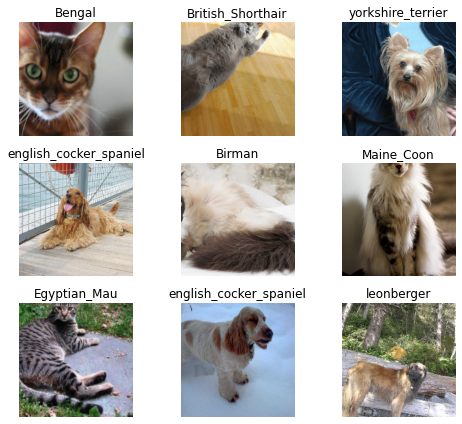

In [0]:
data.show_batch(rows=3, figsize=(7,6))
# for resizng, its a mix of cropping, resizing and possibly padding
# look at your data! Always important

In [0]:
print(data.classes) # all of the possible labels found by using regex on filenames
len(data.classes),data.c # databunch will alwaays have properties called c, can think
# of it has number of classes for now (for classification problems it is at least)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [0]:
# need to give it
# 1. data
# 2. architecture -> works extremly well almost all the time, so just have to decide on size
# that is resnet34 vs resnet50, usually start with small one for speed!
# 3. metrics, asking to print out error rate
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# what is it downloading, its downloading the resnet34 pretrained weights
# that means this model has already been trained for a particular task
# It was actually trained using ImageNet. Downloading the pretrained weights
# allows us to start with a pretrained model so it knows already a bit at least about
# recognizing images and even possible pets!

# This is the idea of transfer learning. We take a fitted model and train it
# It turns out that by doing this, you can save a lot of time training
# and need a lot less data as well

# How do we avoid overfitting, we use a validation set
# Our data bunch automatically created a validation set for us

# edge computing? Running model on phone

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
# 4 is nb of times we go through dataset
learn.fit_one_cycle(4)
# one cycle learning is a new approach, much faster

# after 4 epochs, we got an error rate of
# comparing to the academic paper we got the data from, they got an accuracy of 59%
# Note that it was in 2012 but it was a highly specific animal model
# This is a testament to how far deep learning has come

epoch,train_loss,valid_loss,error_rate,time
0,1.360790,0.323773,0.106901,01:35
1,0.600298,0.236290,0.075101,01:35
2,0.385482,0.211812,0.064276,01:34
3,0.284862,0.203148,0.071042,01:34


In [0]:
# this save the weights we trained
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
# We pass in learn object, the learn object knows what your data is and what your model is
interp = ClassificationInterpretation.from_learner(learn)

# loss function tells you how good your prediction was
# top losses tells us what we were most wrong about
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

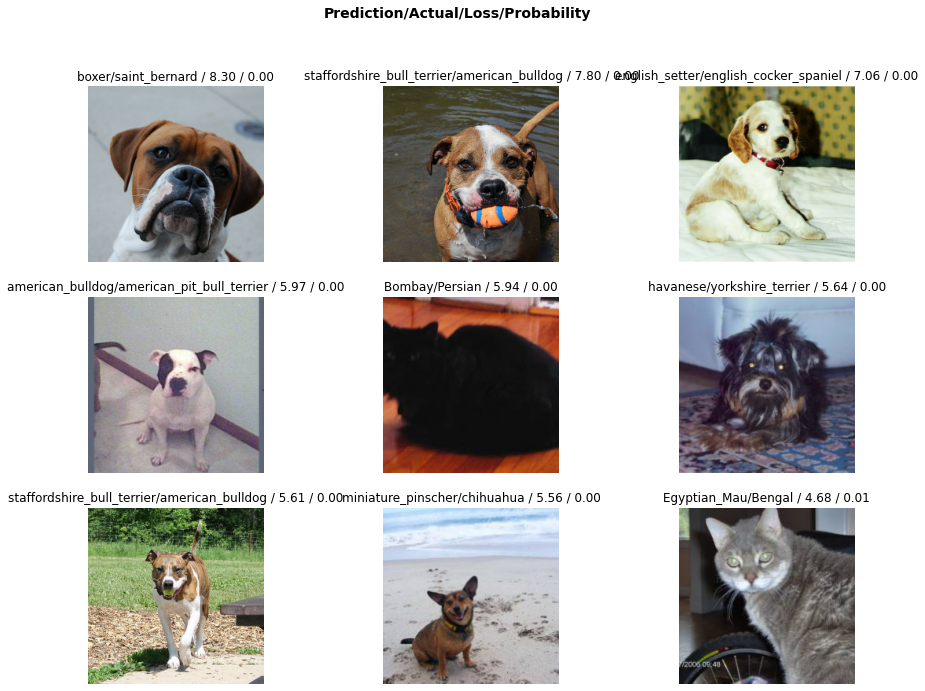

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

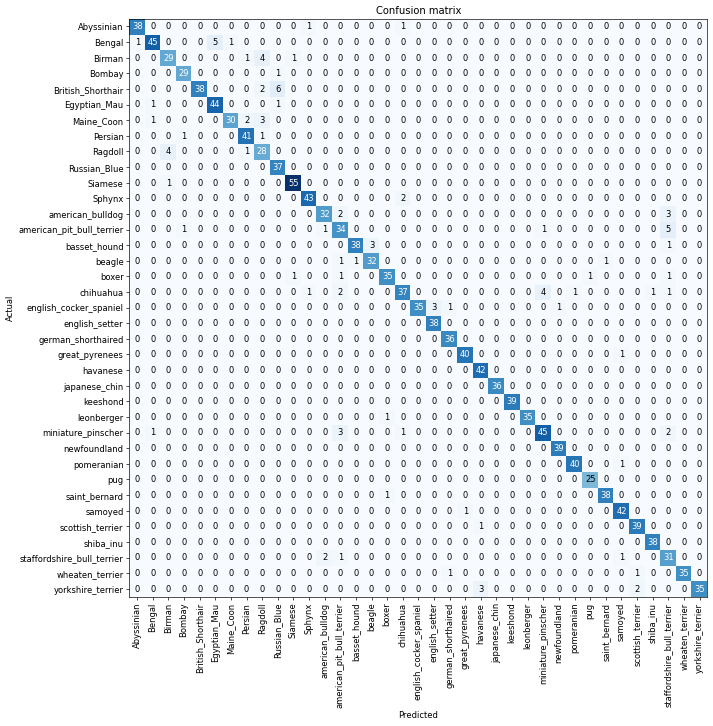

In [0]:
# shows you for every dog or cat, how often was it predicted
# but since our model did pretty well, most points are in the main diagonal
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
# shows you what it got the most wrong
# does it make sense?
interp.most_confused(min_val=2)

[('British_Shorthair', 'Russian_Blue', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Birman', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Maine_Coon', 'Ragdoll', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('basset_hound', 'beagle', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('British_Shorthair', 'Ragdoll', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('chihuahua', 'american_pit_bull_terrier', 2),
 ('miniature_pinscher', 'staffordshire_bull_terrier', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('yorkshire_terrier', 'scottish_terrier', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
# lets make our model better using fine-tuning
# when we trained the model, we basically just added a few layers at the end and 
# trained those layers instead of training the whole thing
learn.unfreeze()
# unfreeze says please train the whole model

# we can actually vizualise layers of conv nets
# (see Matthew D. Zeiler paper on Visualizing layers)
# then from each layer you can kinda tell what its looking for
# and at each layer it gets more complex
# first layer might just be a line, second layer, two lines then after that
# maybe a pattern or more complex geometric shape

# when we first trained the model, we kept all these pre trained models,
# now were seeing if we can make these better by retraining whole model
# but we can note that the firt few layers, like the first one that detects
# straight lines, wont really change even for our personal dataset. This might
# explain why our model performed so poorly
# So we have to change that, we just broke the model

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.681894,0.351436,0.108931,01:37


In [0]:
# now we reload the model we had trained before we broke it
learn.load('stage-1');

In [0]:
# This finds out the fastest we can train NN
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


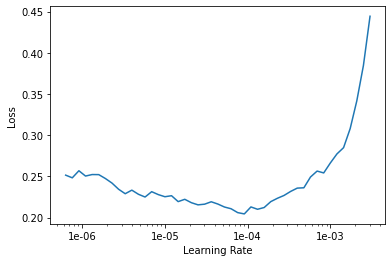

In [0]:
# plot the results of lr_find, tells you about learning rate
# as we increase learning rate, we see that loss gets worst
learn.recorder.plot()

In [0]:
learn.unfreeze()
# looking at function, default is 0.003 which looking at the graph is pretty bad
# we decided to use 1e-6 since it seems to work alright
# but theres no point in training all the layers with this learning rate
# we know that the later layers worked fine. So we can past a range of learning rates
# this basically says train the very first layers with 1e-6 and the last few layers
# with 1e-4 and then use some number in the middle for the middle layers
# Usually set your lower bound to something like 10x smaller than upper bound
# and make sure to select bounds that are far away from the point where things started
# getting bad
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.244673,0.196016,0.064953,01:37
1,0.232695,0.186256,0.065629,01:37


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
# Lets try running it on a larger NN!
# Using resnet 50 now
# Note if you out of memory, then just make bs smaller
# running on smaller bs is fine, just might take a bit longer
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


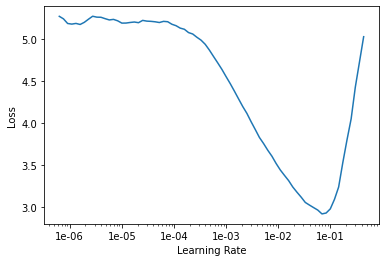

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.731662,0.298240,0.098782,02:36
1,0.522650,0.274461,0.090663,02:34
2,0.396626,0.241599,0.079838,02:34
3,0.374924,0.280418,0.087280,02:33
4,0.273924,0.218149,0.072395,02:34
5,0.171340,0.191182,0.062923,02:34
6,0.134749,0.155512,0.052774,02:34
7,0.107068,0.155413,0.054127,02:36


In [0]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
# might get a tiny improvement here but basically resnet50 is already a good model
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.110645,0.159432,0.047361,02:48
1,0.120699,0.154985,0.050744,02:49
2,0.087913,0.156916,0.052097,02:47


If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
# if you're a domain expert, you might find that these most confused classes make sense
interp.most_confused(min_val=2)

[('Bengal', 'Egyptian_Mau', 8),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Ragdoll', 'Birman', 6),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Egyptian_Mau', 'Abyssinian', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Persian', 'Ragdoll', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'american_bulldog', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('keeshond', 'leonberger', 2)]

## Other data formats

In [0]:
# homework for this week and get your own image dataset and train it!
path = untar_data(URLs.MNIST_SAMPLE); path
# note that mnist dataset is already split up into training, valid and test set

PosixPath('/root/.fastai/data/mnist_sample')

In [0]:
path.ls()
(path/'train').ls()
# note that is an iamgenet style dataset where folder name is label

tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

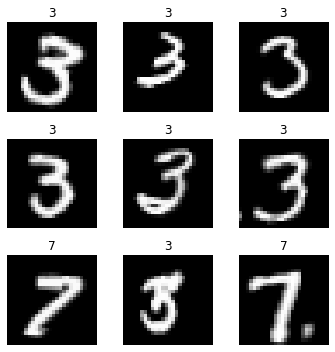

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.188808,0.087953,0.964181,00:20
1,0.108969,0.050036,0.983808,00:19


In [0]:
# might also get data from csv file
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

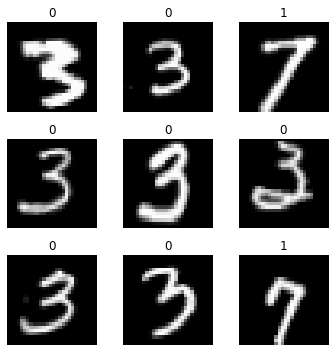

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']